In [1]:
import pandas as pd
from google.oauth2 import service_account
from google.cloud import bigquery

from pycaret.regression import setup, plot_model, create_model

In [2]:
credentials = service_account.Credentials.from_service_account_file(
    "brasil-aberto-443222-aa742cb8970f.json"
)

client = bigquery.Client("brasil-aberto-443222", credentials=credentials)

In [3]:
query = """
with enem as (
select
    enem.`CO_MUNICIPIO_ESC`, enem.`Q006`,
    avg(`NU_NOTA_CH`
    + `NU_NOTA_CN`
    + `NU_NOTA_LC`
    + `NU_NOTA_MT`
    + `NU_NOTA_REDACAO`) as nota_media,
from `brasil-aberto-443222.microdados_abertos.enem` as enem
where
    `NU_NOTA_CH`
    + `NU_NOTA_CN`
    + `NU_NOTA_LC`
    + `NU_NOTA_MT`
    + `NU_NOTA_REDACAO`
    > 0
    and enem.`IN_TREINEIRO` != 1
    and enem.`CO_MUNICIPIO_ESC` is not null
group by enem.`CO_MUNICIPIO_ESC`, enem.`Q006`
)

select
  enem.`Q006`,
  enem.nota_media,
  ips.pop,
  ips.pib_pc,
  -- Nutrição e Cuidados Médicos Básicos
  ips.cv_polio,
  ips.hcsap,
  ips.macsap,
  ips.mi5,
  ips.subnutricao,
  -- Abastecimento e Esgotamento
  ips.aavrd,
  ips.esa,
  ips.iaa,
  ips.ipad,
  -- Moradia
  ips.dcra,
  ips.diea,
  ips.dpa,
  ips.dpsa,
  -- Segurança Pessoal
  ips.aj,
  ips.am,
  ips.homicidios,
  ips.mat,
  -- Acesso ao Conhecimento Básico
  ips.aef,
  ips.aem,
  ips.eem,
  ips.disem,
  ips.ideb_ef,
  ips.ref,
  -- Acesso à Informação e Comunicação
  ips.cim,
  ips.di_blf,
  ips.dtm,
  ips.qim,
  -- Saúde e Bem-estar
  ips.ev,
  ips.m15_50,
  ips.mdcnt,
  ips.obesidade,
  ips.suicidios,
  -- Qualidade do Meio Ambiente
  ips.avu,
  ips.eco2h,
  ips.fc,
  ips.ivcm,
  ips.svps,
  -- Direitos Individuais
  ips.apdh,
  ips.eadmn,
  ips.iadj,
  ips.tclp,
  -- Liberdades Individuais e de Escolha
  ips.acle,
  ips.ga19,
  ips.ppau,
  ips.ti,
  -- Inclusão Social
  ips.pgcm,
  ips.pnpcm,
  ips.vci,
  ips.vcn,
  ips.vcm,
  -- Acesso à Educação Superior
  ips.ees,
  ips.mees
from enem
inner join `brasil-aberto-443222.microdados_abertos.municipios_ips` as ips
    on (
        ips.codigo = cast(enem.`CO_MUNICIPIO_ESC` as string)
    )
"""

municipalities_df = client.query(query).to_dataframe()
municipalities_df.head()

,Q006,nota_media,pop,pib_pc,cv_polio,hcsap,macsap,mi5,subnutricao,aavrd,...,ga19,ppau,ti,pgcm,pnpcm,vci,vcn,vcm,ees,mees
0,B,2382.941667,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
1,C,2844.300000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
2,D,2565.800000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
3,A,1947.100000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883
4,F,2703.800000,10392,49662.545891,33.179724,358.306189,169.509361,10.989011,3.942308,34.243243,...,21.978022,0.0,45.529659,0.699233,0.906998,238.095238,39.525692,222.042794,30.726739,45.274883


In [4]:
faixas_de_renda = municipalities_df["Q006"].unique()

In [5]:
dfs = {}

for faixa_de_renda in faixas_de_renda:
    dfs[faixa_de_renda] = municipalities_df[municipalities_df["Q006"] == faixa_de_renda]

In [6]:
models = {}

for faixa_de_renda in faixas_de_renda:
    s = setup(dfs[faixa_de_renda], target="nota_media", session_id=123)

    print(f'Model: {faixa_de_renda}')
    models[faixa_de_renda] = create_model('rf')

,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(4946, 56)"
4,Transformed data shape,"(4946, 56)"
5,Transformed train set shape,"(3462, 56)"
6,Transformed test set shape,"(1484, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: B


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,140.8896,38357.0517,195.8496,0.1572,0.0816,0.0593
1,171.2639,52852.5530,229.8968,0.1139,0.0972,0.0720
2,149.0068,44573.9328,211.1254,0.1674,0.0931,0.0636
3,157.1855,49675.7418,222.8806,0.1021,0.0917,0.0655
4,165.9735,57195.5624,239.1559,0.0772,0.1060,0.0721
5,162.2887,56264.7812,237.2020,0.0997,0.1000,0.0688
6,158.0847,51279.7005,226.4502,0.1379,0.0950,0.0666
7,161.4499,51483.1757,226.8990,0.1399,0.0966,0.0687
8,147.5127,41879.7992,204.6455,0.1259,0.0847,0.0615


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(4667, 56)"
4,Transformed data shape,"(4667, 56)"
5,Transformed train set shape,"(3266, 56)"
6,Transformed test set shape,"(1401, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: C


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,197.1062,71297.9881,267.0168,0.1069,0.1112,0.0810
1,178.2684,61716.1613,248.4274,0.0921,0.1004,0.0723
2,183.6493,69706.0325,264.0190,0.1211,0.1147,0.0777
3,176.4153,58285.0669,241.4230,0.1602,0.0968,0.0710
4,199.7108,70896.5612,266.2641,0.1274,0.1139,0.0846
5,178.9484,61329.5861,247.6481,0.1261,0.1047,0.0752
6,197.6900,72941.1945,270.0763,0.0659,0.1159,0.0836
7,188.2355,65383.1251,255.7012,0.1313,0.1107,0.0809
8,179.5714,60039.3495,245.0293,0.1247,0.1010,0.0727


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(4314, 56)"
4,Transformed data shape,"(4314, 56)"
5,Transformed train set shape,"(3019, 56)"
6,Transformed test set shape,"(1295, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: D


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,218.7513,87549.5579,295.8877,0.1116,0.1199,0.0895
1,206.9774,82112.1983,286.5523,0.0801,0.1160,0.0843
2,211.2795,90398.3126,300.6631,0.0882,0.1313,0.0892
3,218.2409,81473.6887,285.4360,0.1074,0.1134,0.0866
4,210.3888,86862.0415,294.7237,0.1037,0.1196,0.0857
5,198.7231,69565.7164,263.7531,0.0997,0.1051,0.0786
6,201.0779,76064.5887,275.7981,0.0994,0.1141,0.0828
7,204.6411,76724.5915,276.9920,0.0729,0.1133,0.0842
8,223.6357,88427.5560,297.3677,0.0242,0.1173,0.0872


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(3093, 56)"
4,Transformed data shape,"(3093, 56)"
5,Transformed train set shape,"(2165, 56)"
6,Transformed test set shape,"(928, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: A


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,209.9960,87985.6405,296.6237,0.1451,0.1328,0.0929
1,245.6218,118660.8469,344.4718,-0.1040,0.1626,0.1164
2,205.5082,79173.1374,281.3772,0.0751,0.1206,0.0895
3,192.4914,62956.9303,250.9122,0.0771,0.1116,0.0863
4,213.2596,82198.2540,286.7024,0.1403,0.1240,0.0917
5,191.9329,70269.2012,265.0834,0.0472,0.1164,0.0851
6,215.7282,85512.8017,292.4257,0.0205,0.1245,0.0931
7,205.0313,82431.9550,287.1097,0.0843,0.1374,0.0982
8,216.9094,92083.0915,303.4520,0.0962,0.1431,0.0996


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(3163, 56)"
4,Transformed data shape,"(3163, 56)"
5,Transformed train set shape,"(2214, 56)"
6,Transformed test set shape,"(949, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: F


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,213.5238,80420.9228,283.5858,0.1489,0.1080,0.0819
1,236.4495,108789.1265,329.8320,0.0288,0.1374,0.0957
2,224.2421,90696.7438,301.1590,0.0886,0.1161,0.0862
3,240.3534,101887.3702,319.1980,-0.0177,0.1219,0.0912
4,260.1940,124455.1884,352.7821,0.0217,0.1417,0.1043
5,223.1398,99384.0924,315.2524,0.0862,0.1266,0.0896
6,236.2284,97069.8541,311.5604,0.1258,0.1275,0.0965
7,225.4809,91992.5781,303.3028,0.0936,0.1154,0.0850
8,219.2427,95274.3195,308.6654,0.1449,0.1257,0.0876


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(3391, 56)"
4,Transformed data shape,"(3391, 56)"
5,Transformed train set shape,"(2373, 56)"
6,Transformed test set shape,"(1018, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: G


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,246.5301,121722.7481,348.8879,0.0676,0.1731,0.1149
1,220.9419,90811.2136,301.3490,0.1029,0.1180,0.0857
2,202.7565,74294.5049,272.5702,0.1088,0.1038,0.0776
3,207.2068,79514.2655,281.9827,0.1952,0.1104,0.0806
4,212.4057,88709.8913,297.8421,0.1562,0.1172,0.0830
5,223.1862,87134.7088,295.1859,0.0696,0.1097,0.0824
6,245.1833,110710.2401,332.7315,0.1162,0.1329,0.0981
7,224.8430,92581.5532,304.2722,0.1005,0.1151,0.0839
8,223.7365,94574.5779,307.5298,0.1416,0.1211,0.0881


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(2588, 56)"
4,Transformed data shape,"(2588, 56)"
5,Transformed train set shape,"(1811, 56)"
6,Transformed test set shape,"(777, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: H


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,243.7985,112030.2997,334.7093,0.0875,0.1316,0.0968
1,252.1661,111988.6672,334.6471,-0.0194,0.1214,0.0892
2,257.8343,130387.3476,361.0919,0.1743,0.1413,0.1009
3,226.4862,100875.1527,317.6085,-0.0248,0.1144,0.0807
4,228.4227,114427.6779,338.2716,0.1248,0.1546,0.1005
5,267.4116,133305.9519,365.1109,0.1139,0.1411,0.1040
6,248.5089,114970.8004,339.0734,0.1168,0.1269,0.0923
7,234.0820,95019.6235,308.2525,0.0559,0.1178,0.0897
8,258.1869,125598.4985,354.3988,0.1816,0.1392,0.1015


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(3816, 56)"
4,Transformed data shape,"(3816, 56)"
5,Transformed train set shape,"(2671, 56)"
6,Transformed test set shape,"(1145, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: E


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,227.7606,105176.0426,324.3086,0.1075,0.1429,0.0981
1,202.1277,77308.0141,278.0432,0.1624,0.1125,0.0808
2,207.6294,78287.0346,279.7982,0.0970,0.1133,0.0833
3,218.6253,87554.5330,295.8962,0.1174,0.1194,0.0888
4,223.8138,89046.4772,298.4066,0.0269,0.1222,0.0918
5,208.2702,77219.6070,277.8842,0.1690,0.1088,0.0808
6,208.8542,77536.5534,278.4539,0.1567,0.1097,0.0824
7,228.7416,95045.9548,308.2952,0.0939,0.1230,0.0917
8,222.7940,92641.8546,304.3712,0.0617,0.1170,0.0857


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(1253, 56)"
4,Transformed data shape,"(1253, 56)"
5,Transformed train set shape,"(877, 56)"
6,Transformed test set shape,"(376, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: L


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,281.6107,143481.7542,378.7899,0.0408,0.1381,0.1036
1,271.7823,142083.5108,376.9397,0.1055,0.1418,0.1009
2,239.6323,98853.7782,314.4102,-0.0491,0.1108,0.0836
3,245.4213,102031.1801,319.4232,0.0223,0.1107,0.0835
4,270.9028,132563.7243,364.0930,0.0500,0.1352,0.0996
5,271.2322,138258.8641,371.8318,0.1181,0.1416,0.1031
6,252.0469,121508.1171,348.5801,0.1014,0.1355,0.0986
7,258.0521,122304.7809,349.7210,0.1248,0.1298,0.0948
8,239.2024,104953.2956,323.9650,-0.1669,0.1112,0.0813


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(1837, 56)"
4,Transformed data shape,"(1837, 56)"
5,Transformed train set shape,"(1285, 56)"
6,Transformed test set shape,"(552, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: J


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,209.2683,82109.7262,286.5479,0.0956,0.1050,0.0761
1,245.6890,130006.8412,360.5646,0.1425,0.1474,0.0992
2,253.3559,119266.2577,345.3495,0.0582,0.1284,0.0949
3,253.0619,111597.6432,334.0623,0.0415,0.1159,0.0874
4,241.1733,104720.8704,323.6060,0.1161,0.1208,0.0886
5,249.2938,110096.6536,331.8082,0.1365,0.1214,0.0907
6,243.0899,117123.8065,342.2336,0.1100,0.1555,0.1030
7,270.6531,129323.5837,359.6159,0.1335,0.1382,0.1040
8,234.2869,94770.7519,307.8486,0.1240,0.1085,0.0814


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(2030, 56)"
4,Transformed data shape,"(2030, 56)"
5,Transformed train set shape,"(1421, 56)"
6,Transformed test set shape,"(609, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: I


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,255.3718,114837.3591,338.8766,0.0409,0.1241,0.0934
1,262.0620,142537.5631,377.5415,0.0596,0.1478,0.1017
2,233.5418,100702.0616,317.3359,-0.0016,0.1114,0.0812
3,276.8283,135883.0238,368.6231,-0.0246,0.1372,0.1020
4,245.0725,103810.1604,322.1958,0.1759,0.1193,0.0912
5,223.6235,94371.6706,307.1997,0.2061,0.1177,0.0842
6,235.8475,107755.7102,328.2616,0.0623,0.1293,0.0924
7,216.8483,96055.5788,309.9283,0.1694,0.1170,0.0817
8,238.9322,98117.1577,313.2366,0.1166,0.1119,0.0852


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(1502, 56)"
4,Transformed data shape,"(1502, 56)"
5,Transformed train set shape,"(1051, 56)"
6,Transformed test set shape,"(451, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: K


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,241.7461,106862.2592,326.8979,0.1154,0.1205,0.0894
1,234.4618,95941.8604,309.7448,0.1371,0.1117,0.0844
2,217.9660,94378.2945,307.2105,0.1454,0.1192,0.0843
3,293.8742,148298.8643,385.0959,-0.0425,0.1366,0.1033
4,222.9028,91711.6287,302.8393,0.1172,0.1058,0.0776
5,270.9395,139370.9015,373.3241,0.0222,0.1404,0.1040
6,233.9051,100111.8731,316.4046,0.1135,0.1162,0.0842
7,209.6928,74850.3916,273.5880,0.0662,0.0961,0.0728
8,246.2427,105017.6408,324.0643,0.1216,0.1164,0.0892


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(811, 56)"
4,Transformed data shape,"(811, 56)"
5,Transformed train set shape,"(567, 56)"
6,Transformed test set shape,"(244, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: P


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,264.7451,131091.5296,362.0656,0.0608,0.1310,0.0938
1,263.2494,115021.6300,339.1484,0.0683,0.1203,0.0920
2,263.0070,126229.5049,355.2879,0.0320,0.1264,0.0940
3,270.5546,120931.5014,347.7521,0.2078,0.1257,0.0973
4,225.0511,92931.8531,304.8473,0.2395,0.1085,0.0787
5,233.4242,94023.0786,306.6318,0.2646,0.1067,0.0809
6,260.6585,120408.8568,346.9998,-0.1133,0.1181,0.0856
7,271.0254,134320.8240,366.4981,0.1062,0.1316,0.0975
8,283.4602,128895.1992,359.0198,0.2017,0.1251,0.1007


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(1037, 56)"
4,Transformed data shape,"(1037, 56)"
5,Transformed train set shape,"(725, 56)"
6,Transformed test set shape,"(312, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: M


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,278.6895,132615.4146,364.1640,-0.0302,0.1336,0.1035
1,260.6802,137479.5373,370.7823,0.1992,0.1466,0.1024
2,264.3834,114415.7940,338.2540,0.1919,0.1176,0.0922
3,222.4313,91074.5805,301.7857,-0.3494,0.0970,0.0695
4,263.0085,117821.9104,343.2520,0.0970,0.1280,0.0952
5,281.7534,126897.6671,356.2270,0.0019,0.1258,0.1013
6,261.6142,115049.9807,339.1902,-0.0723,0.1138,0.0868
7,283.2509,164923.2537,406.1074,-0.0032,0.1665,0.1152
8,261.8379,131725.7960,362.9405,0.1433,0.1380,0.0960


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(1034, 56)"
4,Transformed data shape,"(1034, 56)"
5,Transformed train set shape,"(723, 56)"
6,Transformed test set shape,"(311, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: N


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,223.7798,88476.9992,297.4508,0.1720,0.1026,0.0764
1,255.0390,116990.5201,342.0388,-0.0035,0.1251,0.0945
2,199.1519,82133.8802,286.5901,0.1087,0.1002,0.0689
3,259.6897,124594.4828,352.9794,0.1821,0.1289,0.0949
4,274.9746,115872.6276,340.4007,0.2138,0.1221,0.0978
5,221.6665,88834.4089,298.0510,0.2125,0.1080,0.0800
6,254.3180,114561.7452,338.4697,0.1527,0.1232,0.0929
7,278.1614,154515.2936,393.0843,0.0553,0.1424,0.1014
8,256.5318,113626.3405,337.0851,-0.0722,0.1167,0.0877


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(957, 56)"
4,Transformed data shape,"(957, 56)"
5,Transformed train set shape,"(669, 56)"
6,Transformed test set shape,"(288, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: O


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,260.8368,104882.8761,323.8563,0.1139,0.1135,0.0919
1,239.7900,93713.7510,306.1270,0.1711,0.1052,0.0814
2,241.2685,104171.5731,322.7562,0.1837,0.1176,0.0880
3,179.4747,59812.8284,244.5666,0.2589,0.0811,0.0594
4,267.0063,106195.3539,325.8763,0.1142,0.1089,0.0880
5,279.1340,138839.3272,372.6115,-0.1084,0.1279,0.0942
6,233.1311,98204.5463,313.3760,0.0222,0.1107,0.0821
7,230.1474,95944.4889,309.7491,0.0984,0.1094,0.0816
8,233.6773,94921.1410,308.0927,0.0548,0.1065,0.0818


,Description,Value
0,Session id,123
1,Target,nota_media
2,Target type,Regression
3,Original data shape,"(807, 56)"
4,Transformed data shape,"(807, 56)"
5,Transformed train set shape,"(564, 56)"
6,Transformed test set shape,"(243, 56)"
7,Numeric features,54
8,Categorical features,1
9,Preprocess,True


Model: Q


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,259.0454,135568.0206,368.1956,0.1979,0.1357,0.0930
1,263.9091,111039.7953,333.2263,0.1532,0.1246,0.0980
2,294.1073,145225.8731,381.0851,0.0738,0.1322,0.1024
3,250.8554,114879.0774,338.9382,0.0405,0.1184,0.0858
4,285.3927,147614.1919,384.2059,0.2487,0.1436,0.1074
5,304.9759,151099.2146,388.7148,0.2248,0.1421,0.1128
6,281.0658,140113.5945,374.3175,-0.1053,0.1336,0.1001
7,242.9314,106543.8653,326.4106,0.3062,0.1112,0.0836
8,236.4094,117065.8434,342.1489,0.0972,0.1156,0.0787


In [7]:
feature_importances = []

for faixa_de_renda in faixas_de_renda:
    if hasattr(models[faixa_de_renda], "feature_importances_"):
        d = dict(zip(models[faixa_de_renda].feature_names_in_, models[faixa_de_renda].feature_importances_))
        d["faixa_de_renda"] = faixa_de_renda
        
        del d[f'Q006_{faixa_de_renda}']
        
        feature_importances.append(d)

features_df = pd.DataFrame(feature_importances)
features_df.head()

,pop,pib_pc,cv_polio,hcsap,macsap,mi5,subnutricao,aavrd,esa,iaa,...,ppau,ti,pgcm,pnpcm,vci,vcn,vcm,ees,mees,faixa_de_renda
0,0.039311,0.015885,0.013839,0.014539,0.020059,0.020535,0.017970,0.011882,0.023774,0.013782,...,0.015840,0.019716,0.011988,0.012258,0.004871,0.017820,0.012553,0.012824,0.012289,B
1,0.042865,0.016966,0.013118,0.016756,0.019050,0.019269,0.026602,0.013079,0.023256,0.015421,...,0.014849,0.014863,0.024231,0.014777,0.007047,0.013923,0.016206,0.011604,0.011459,C
2,0.051555,0.017535,0.012476,0.025220,0.021468,0.019398,0.021551,0.014800,0.015655,0.021502,...,0.014080,0.017534,0.015332,0.012016,0.004102,0.015232,0.016461,0.014845,0.015263,D
3,0.026357,0.012794,0.014501,0.020698,0.014221,0.021130,0.019171,0.013964,0.018475,0.012684,...,0.019181,0.019473,0.017364,0.013901,0.010230,0.016581,0.019926,0.012503,0.010381,A
4,0.072495,0.023354,0.019154,0.023639,0.020357,0.018258,0.021010,0.013698,0.020644,0.016512,...,0.016115,0.013915,0.013202,0.011437,0.005743,0.015190,0.015319,0.014008,0.012969,F


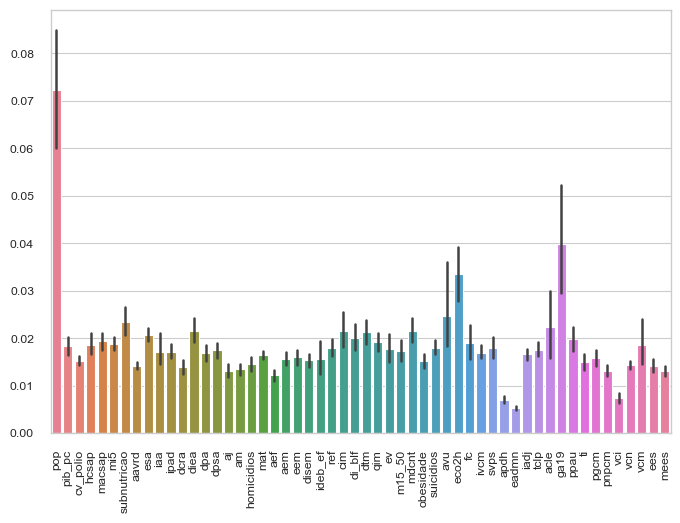

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="paper", style="whitegrid")

sns.barplot(data=features_df)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='faixa_de_renda', ylabel='ga19'>

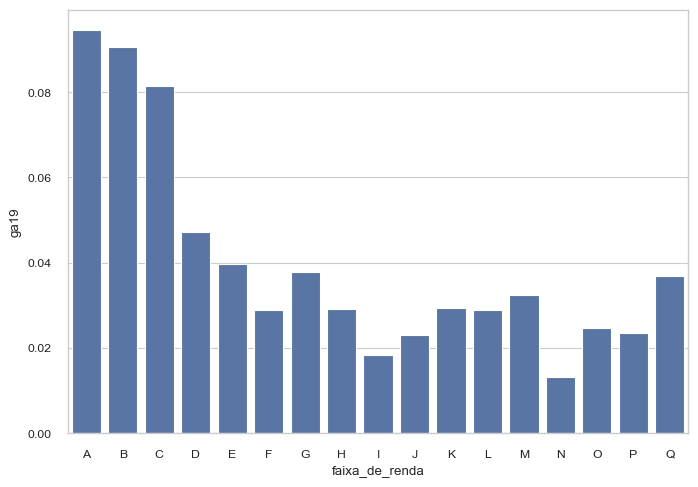

In [9]:
sns.barplot(data=features_df, x="faixa_de_renda", y="ga19", order=sorted(list(faixas_de_renda)))

<Axes: xlabel='faixa_de_renda', ylabel='pop'>

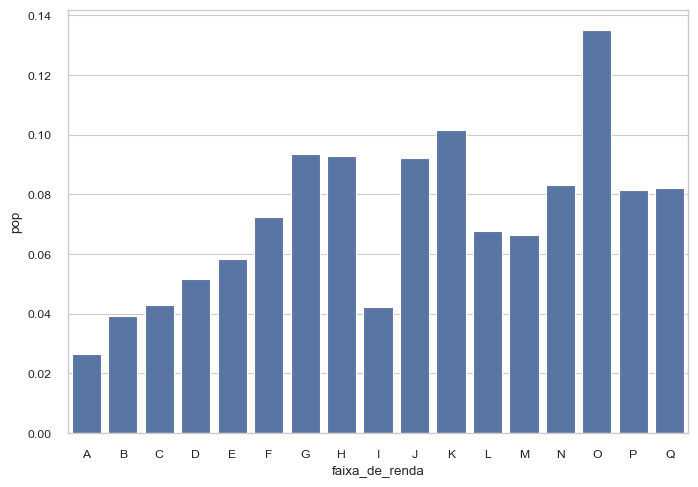

In [10]:
sns.barplot(data=features_df, x="faixa_de_renda", y="pop", order=sorted(list(faixas_de_renda)))